# FAQ and Attentions
* Copy and move this template to your Google Drive. Name your notebook by your team ID (upper-left corner). Don't eidt this original file.
* This template covers most questions we want to ask about your reproduction experiment. You don't need to exactly follow the template, however, you should address the questions. Please feel free to customize your report accordingly.
* any report must have run-able codes and necessary annotations (in text and code comments).
* The notebook is like a demo and only uses small-size data (a subset of original data or processed data), the entire runtime of the notebook including data reading, data process, model training, printing, figure plotting, etc,
must be within 8 min, otherwise, you may get penalty on the grade.
  * If the raw dataset is too large to be loaded  you can select a subset of data and pre-process the data, then, upload the subset or processed data to Google Drive and load them in this notebook.
  * If the whole training is too long to run, you can only set the number of training epoch to a small number, e.g., 3, just show that the training is runable.
  * For results model validation, you can train the model outside this notebook in advance, then, load pretrained model and use it for validation (display the figures, print the metrics).
* The post-process is important! For post-process of the results,please use plots/figures. The code to summarize results and plot figures may be tedious, however, it won't be waste of time since these figures can be used for presentation. While plotting in code, the figures should have titles or captions if necessary (e.g., title your figure with "Figure 1. xxxx")
* There is not page limit to your notebook report, you can also use separate notebooks for the report, just make sure your grader can access and run/test them.
* If you use outside resources, please refer them (in any formats). Include the links to the resources if necessary.

# Introduction

## Background

  Adverse drug-drug interaction (DDI) is the unintended molecular interactions between drugs. It’s a prominent cause of patient morbidities/mortalities, incurring higher costs and risking patient safety. The difficulty of mitigating this issue stems from a couple of factors: 

  * The molecular structure of drugs are complex, consisting of many units and substructures
  * Drug development is a process that requires highly specialized knowledge
  * Trials to test drugs and post-market surveillance are long and expensive processes

  With respect to applying ML to this topic, there are also a couple of issues:
  
  * There is a relatively light amount of training data that exists, due to the slow reporting of DDI instances
  * Deep learning models have a large number of parameters, making interpretation of the model’s results difficult. Thus, extracting the reasoning for why a DDI is occurring can be hard for researchers to glean.
  * DDIs usually result from the reactions of only a few sub-structures of a drug’s entire molecule, but many drug-drug pairs have significant overlaps on larger but irrelevant substructures. This skews the results of DDI prediction.

  There is major interest in predicting whether two drugs will interact (especially during the design process) to reduce testing/development costs and improving patient safety.

### The Current State of the Art
 
  Deep learning models have been successfully used to predict DDIs, however such previous models often generate drug representations using the entire chemical representation, causing learned representations to be potentially biased toward the large, irrelevant substructures and ultimately nullify learned drug similarities and predictions.

## CASTER
  The ChemicAl SubstrucTurE Representation framework, or CASTER, was introduced as a DDI prediction model, improving on the weaknesses of prior works. In particular it has a couple of notable parts:

  * A sequential pattern mining method to efficiently characterize the functional sub-structures of drugs. This accounts for the interaction mechanism between drugs, as interactions depend primarily on the reaction between these functional sub-structures.     
  * An autoencoding module that extracts information from both labeled and unlabeled chemical structure data and embeds patterns into a latent-feature representation that can be generalized to novel drug pairs.
  * A dictionary learning module to explain the prediction using only a small set of coefficients measuring the relevance of each input sub-structure to the DDI prediction. This is done by projecting drug pairs onto the subspace defined by the generalized embeddings generated by the autoencoding module.

  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).


# CASTER
The **ChemicAl SubstrucTurE Representation** framework (CASTER) was introduced as a DDI prediction model, improving on the weaknesses of prior works. The authors presented the following hypotheses:
1.  The CASTER model will provide more accurate DDI predictions when compared with other established models.
2.  The usage of unlabelled data to generate frequent sub-structure features improves performance in situations with limited labeled datasets.
3.  CASTER’s sub-structure dictionary can help human operators better comprehend the final result.

### Architecture

![caster_structure.png](img/caster_block_diagram.png)

The model consists of a few notable parts:
* **Sequential Pattern Mining (SPM)**
    * The SMILEs strings are initially passed through a sequential pattern mining process to find frequently occurring substructures
        * The frequent substructures are put into a dictionary (*u[1-k]*)
    * SMILEs pairs are encoded into multi-hot vectors of their frequent substructures and combined into a single functional representation (*X*)
* **Encoder**
    * The functional representation is passed through the encoder to make a latent feature vector (*z*)
    * The individual freq. substructures, as one-hot vectors, are also passed through the encoder to make a latent dictionary of substructures (*b[1-k]*)
* **Predictor**
    * The latent representation is projected onto the latent dictionary to form a set of coefficients (*r[1-k]*)
    * The coefficients are passed through a standard fully connected NN.
* **Decoder**
    * The latent representation is passed through the decoder to reconstruct the functional representation and help comprehend the result

* what did the paper propose
* what is the innovations of the method
* how well the proposed method work (in its own metrics)
* what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).

# Scope of Reproducibility:

# Methodology
## Setup
This notebook was run with Python >=3.8. The required packages below can be installed using conda, venv, or pip.
* numpy
* torch
* subword_nmt
* codecs
* pandas
* scikit-learn
* tqdm
* matplotlib

In [1]:
import numpy as np

#Basic torch imports
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

#Used for parsing the misc datasets
from subword_nmt.apply_bpe import BPE
import codecs

#For dataset preparation and evaluation
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold

#Misc.
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

In [2]:
QUICK_DEMO = True

#Defines configuration for the data/model/training.
CONFIG = {}

#Learning rate
CONFIG['LR'] = 1e-3
CONFIG['batch_size'] = 256
CONFIG['batch_first'] = True

#Number of pretrain and training epochs
CONFIG['pretrain_epochs'] = 3
CONFIG['train_epochs'] = 3

#Self defined coefficient to multiply with the reconstruction loss.
CONFIG['reconstruction_coefficient'] = 1e-1  # 1e-2
#Defines a stopping point for pre-training the encoder/decoder
CONFIG['recon_threshold'] = 0.0005 # change later
CONFIG['projection_coefficient'] = 1e-1  # 1e-2

#The width of the drug-drug pair's multi-hot functional representation
CONFIG['input_dim'] = 1722
CONFIG['num_class'] = 2

#===== Encoder/Decoder Parameters =====
CONFIG['encode_fc1_dim'] = 500  # encoder fc1
CONFIG['encode_fc2_dim'] = 50  # encoder fc2
CONFIG['decode_fc1_dim'] = 500  # decoder fc1
CONFIG['decode_fc2_dim'] = CONFIG['input_dim']  # decoder reconstruction

#===== Deep Predictor Parameters =====
CONFIG['magnify_factor'] = 100
CONFIG['predict_dim'] = 1024 # for every layer
CONFIG['predict_out_dim'] = 1 # predictor out

CONFIG['lambda1'] = 1e-2  # L1 regularization coefficient
CONFIG['lambda2'] = 1e-1  # L2 regulatization coefficient
CONFIG['lambda3'] = 1e-5  # L2 regulatization coefficient


##  Data
The data that CASTER ingests consists of 3 datasets:
  * unsup_dataset.csv = A dataset of randomly combined pairs of SMILEs strings drawn from FooDB (a db of food constituent molecules) and all drugs, drawn from DrugBank
    * This unsupervised dataset is used to help find frequent SMILEs substructures
  * BIOSNAP/sup*.csv = A dataset from Stanford's Biomedical Network Dataset indicating pairs of SMILEs strings and presence of DDI
    * These are the supervised datasets for training the predictor
  * subword_units_map.csv = The 1722 frequent patterns extracted from the unsupervised strings, already produced by the sequential pattern mining (SPM) routine
  
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.

In [3]:
#===== DATASET DEFINITIONS =====
vocab_path = "data/codes.txt"
bpe_codes_fin = codecs.open(vocab_path)
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

#Get frequent substructures
vocab_map = pd.read_csv('data/subword_units_map.csv')
idx2word = vocab_map['index'].values
words2idx = dict(zip(idx2word, range(0, len(idx2word))))

#===== Helper functions =====
#Map the smiles strings into multi-hot representations of substructures.
def smiles2index(s1, s2):
    t1 = bpe.process_line(s1).split() #split
    t2 = bpe.process_line(s2).split() #split
    i1 = [words2idx[i] for i in t1] # index
    i2 = [words2idx[i] for i in t2] # index
    return i1, i2

#Combine both multi-hot representations into a single multi-hot (the functional representation)
def index2multi_hot(i1, i2):
    v_d = np.zeros(len(idx2word),)
    v_d[i1] = 1
    v_d[i2] = 1
    return v_d

#Final product, takes two smiles strings and turns them into the functional representation multi-hot.
def smiles2vector(s1, s2):
    i1, i2 = smiles2index(s1, s2)
    v_d = index2multi_hot(i1, i2)
    return v_d

#===== Datasets =====
class sup_data(data.Dataset):

    def __init__(self, list_IDs, labels, df_ddi):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.df = df_ddi
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        index = self.list_IDs[index]
        # Load data from sample and get multi-hot
        s1 = self.df.iloc[index].Drug1_SMILES
        s2 = self.df.iloc[index].Drug2_SMILES
        v_d = smiles2vector(s1, s2)
        #Get label
        y = self.labels[index]
        #Return combined multi-hot and its label.
        return v_d, y
    
class unsup_data(data.Dataset):

    def __init__(self, list_IDs, df):
        'Initialization'
        self.list_IDs = list_IDs
        self.df = df

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        index = self.list_IDs[index]
        s1 = self.df.iloc[index].input1_SMILES
        s2 = self.df.iloc[index].input2_SMILES
        v_d = smiles2vector(s1, s2)
        return v_d

In [4]:
#Read datasets
df_unsup = pd.read_csv('data/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
df_ddi = pd.read_csv('data/BIOSNAP/sup_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles

#Print some basic info about the datasets 
print("="*30)
print("TOTAL UNSUPERVISED SET")
print("="*30)
print("# of samples:",len(df_unsup))
print("# of drug-food pairs:",sum(df_unsup.type == "df_pair"))
print("# of drug-drug pairs:",sum(df_unsup.type == "dd_pair"))
print("="*30)
print("BIOSNAP TRAIN/VAL SET")
print("="*30)
print("# of samples:",len(df_ddi))
print("# of DDIs:",sum(df_ddi.label == 1.0))

#Do kfold
kf = KFold(n_splits = 8, shuffle = True, random_state = 3)

#Get the 1st fold index
fold_index = next(kf.split(df_ddi), None)

ids_unsup = df_unsup.index.values
partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
labels_sup = df_ddi.label.values

LOADER_PARAMS = {
    'batch_size': CONFIG["batch_size"],
    'shuffle': True,
    'num_workers': 0
    }

unsup_set = unsup_data(ids_unsup, df_unsup)
unsup_generator = data.DataLoader(unsup_set, **LOADER_PARAMS)

training_set = sup_data(partition_sup['train'], labels_sup, df_ddi)
training_generator_sup = data.DataLoader(training_set, **LOADER_PARAMS)

validation_set = sup_data(partition_sup['val'], labels_sup, df_ddi)
validation_generator_sup = data.DataLoader(validation_set, **LOADER_PARAMS)

TOTAL UNSUPERVISED SET
# of samples: 441853
# of drug-food pairs: 220926
# of drug-drug pairs: 220927
BIOSNAP TRAIN/VAL SET
# of samples: 66432
# of DDIs: 33243


##   Model

Based on CASTER's github, the model was defined with the following parameters:

# TODO: Fill out

The model includes the model definition which usually is a class, model training, and other necessary parts.
* Model architecture: layer number/size/type, activation function, etc
* Training objectives: loss function, optimizer, weight of each loss term, etc
* Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
* The code of model should have classes of the model, functions of model training, model validation, etc.
* If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

In [5]:
class CASTER(nn.Sequential):

    def __init__(self, **config):
        super(CASTER, self).__init__()
        self.input_dim = config['input_dim']
        self.num_class = config['num_class']
        self.lambda3 = config['lambda3']        
        self.encode_fc1_dim = config['encode_fc1_dim']
        self.encode_fc2_dim = config['encode_fc2_dim']
        self.decode_fc1_dim = config['decode_fc1_dim']
        self.decode_fc2_dim = config['decode_fc2_dim']
        self.predict_dim = config['predict_dim']
        self.predict_out_dim = config['predict_out_dim']
        self.mag_factor = config['magnify_factor']        

        # encoder: two layer NN
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.encode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.encode_fc1_dim, self.encode_fc2_dim)
        )
        
        # decoder: two layer NN
        self.decoder = nn.Sequential(
            nn.Linear(self.encode_fc2_dim, self.decode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.decode_fc1_dim, self.decode_fc2_dim)
        )

        # predictor: eight layer NN
        self.predictor = nn.Sequential(
            # layer 1
            nn.Linear(self.input_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 2
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 3
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 4
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 5
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 6
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, 64),
            nn.ReLU(True),
            # output layer
            nn.Linear(64, self.predict_out_dim)
        )

    def dictionary_encoder(self, z, latent_dict):
        '''
        :param Z_D: batch_size x encode_fc2_dim
        :param Z_f: encode_fc2_dim x eta
        :return: sparse code X_o: batch_size x eta
        '''       
        
        DTD = torch.matmul(latent_dict, latent_dict.transpose(2, 1))  # D is Dictionary;  D^T D encode_dim x eta
        DTD_inv = torch.inverse(DTD + self.lambda3 * torch.eye(self.input_dim))  # (D^T D + \lambda2 I )^{-1} D^T D, eta x eta
        DTD_inv_DT = torch.matmul(DTD_inv, latent_dict)  

        r = z[:,None,:].matmul(DTD_inv_DT.transpose(2, 1)).squeeze(1) # batch_size x eta    
        return r

    def forward(self, x_vec):
        '''
        :param x_vec: batch_size x width of multi-hot functional
        :return: recon, r_vec, score
        '''
        _, x_width = x_vec.shape
        
        # Encode functional representation into latent representation 
        z_vec = self.encoder(x_vec)
        
        # Create latent dictionary using encoder
        latent_dict = self.encoder(torch.eye(x_width))
        latent_dict = latent_dict.mul(x_vec[:,:,None]) 
        
        # Use dictionary to get coeffs/r_vec
        r_vec = self.dictionary_encoder(z_vec, latent_dict)

        # Pass coeffs through the deep predictor
        score = self.predictor(self.mag_factor * r_vec)

        # Decode latent representation
        recon_temp = self.decoder(z_vec)
        reconstructed = torch.sigmoid(recon_temp)
        
        # print(reconstructed, r_vec, score, latent_dict, z_vec)
        return reconstructed, r_vec, score, latent_dict, z_vec

#Instantiated model
model = CASTER(**CONFIG)

'''
def train_model_one_iter(model, loss_func, optimizer):
    pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
    train_model_one_iter(model, loss_func, log_reg_optimizer)
    train_loss, valid_loss = None, None
    print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))
'''

'\ndef train_model_one_iter(model, loss_func, optimizer):\n    pass\n\nnum_epoch = 10\n# model training loop: it is better to print the training/validation losses during the training\nfor i in range(num_epoch):\n    train_model_one_iter(model, loss_func, log_reg_optimizer)\n    train_loss, valid_loss = None, None\n    print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))\n'

## Training
Training proceeds in two parts. 
1. Pre-training: Focused on getting the autoencoder to find the most efficient latent representation for the functional representation.
2. Training: The predictor is trained with the linear coefficients from combining the latent dictionary with the latent representation.

In [6]:
#Misc loss histories
loss_r_history = []
loss_p_history = []
loss_c_history = []
loss_history = []

#How many epochs to devote to training the encoder/decoder
PRETRAIN_EPOCHS = CONFIG['pretrain_epochs']
#Defines an early stopping point for pre-training the encoder/decoder
RECON_THRESH = CONFIG['recon_threshold']
#Self defined coefficient to multiply with the reconstruction loss.
RECON_LOSS_COEFF = CONFIG['reconstruction_coefficient']

TRAIN_EPOCHS = CONFIG["train_epochs"]
PROJ_COEFF = CONFIG['projection_coefficient']
LAM1 = CONFIG['lambda1']
LAM2 = CONFIG['lambda2']

LR = CONFIG['LR']
BATCH_SIZE = CONFIG["batch_size"]
opt = torch.optim.Adam(model.parameters(), lr = LR)

In [7]:
#===== PRE-TRAINING =====
if not QUICK_DEMO:
    len_unsup = len(unsup_generator)
    for pre_epo in range(PRETRAIN_EPOCHS):

        #Use unsupervised datasat to train encoder/decoder
        for iter_idx, v_D in enumerate(unsup_generator):
            v_D = v_D.float()
            # print(model.forward(v_D).shape)
            recon, code, score, Z_f, z_D = model(v_D)
            
            loss_r = RECON_LOSS_COEFF * F.binary_cross_entropy(recon, v_D)
            
            loss_p = PROJ_COEFF * (torch.norm(z_D - torch.matmul(code, Z_f)) + \
                    LAM1 * torch.sum(torch.abs(code)) / BATCH_SIZE + \
                    LAM2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            total_loss = loss_r + loss_p
            
            loss_r_history.append(loss_r.detach())
            loss_p_history.append(loss_p.detach())
            loss_history.append(total_loss.detach())

            opt.zero_grad()
            total_loss.backward()
            opt.step()
            
            # if(i % 10 == 0):
            print('Pre-Training at Epoch ' + str(pre_epo) + \
                    ' iteration ' + str(iter_idx) + \
                    ', total loss is ' + '%.3f' % (total_loss.cpu().detach().numpy()) + \
                    ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) + \
                    ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            #If the reconstruction loss is smaller than the specified threshold, finish the pre-training and go train.
            if loss_r < RECON_THRESH:
                break
            
            # save pretraining checkpoint for reuse
            if iter_idx == int(len_unsup/4):
                torch.save(model, 'model_pretrain_checkpoint_1.pt')
            if iter_idx == int(len_unsup/2):
                torch.save(model, 'model_pretrain_checkpoint_1.pt')
        torch.save(model, 'model_nn_pretrain.pt')

In [8]:
#===== TRAINING =====
if not QUICK_DEMO:
    sigmoid = torch.nn.Sigmoid()
    bce_loss = torch.nn.BCELoss()

    for tr_epo in range(TRAIN_EPOCHS):
        for iter_idx, (v_D, label) in enumerate(training_generator_sup):
            v_D = v_D.float()
            recon, code, score, Z_f, z_D = model(v_D)
            label = Variable(torch.from_numpy(np.array(label)).long())
            n = torch.squeeze(sigmoid(score))
            
            loss_c = bce_loss(n, label.float())
            loss_r = RECON_LOSS_COEFF * F.binary_cross_entropy(recon, v_D)
            
            loss_p =    PROJ_COEFF * (torch.norm(z_D - torch.matmul(code, Z_f)) + \
                        LAM1 * torch.sum(torch.abs(code)) / BATCH_SIZE + \
                        LAM2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            total_loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r.detach())
            loss_p_history.append(loss_p.detach())
            loss_c_history.append(loss_c.detach())
            loss_history.append(total_loss.detach())

            opt.zero_grad()
            total_loss.backward()
            opt.step()
                    
            print(  'Training at Epoch ' + str(tr_epo) + \
                    ' iteration ' + str(iter_idx) + \
                    ', total loss is ' + '%.3f' % (total_loss.detach().numpy()) + \
                    ', proj loss is ' + '%.3f' % (loss_p.detach().numpy()) + \
                    ', recon loss is ' + '%.3f' % (loss_r.detach().numpy()) + \
                    ', classification loss is ' + '%.3f' % (loss_c.detach().numpy()))

                
        with torch.set_grad_enabled(False):
            auc, logits = test_dde_nn(validation_generator_sup, model)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
                path = 'model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
                torch.save(model, path)    
            print('Test at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))

## Ablation Model: Logistic Regression

One of the ablations we proposed (and one that was also suggested in the paper) was using logistic regression (LR) instead of CASTER's deep predictor. Specifically, the pair's functional representation (sub-structured/post pattern-mined) is classified using LR. According to the paper, though far lighter in parameter count, it was not chosen due its weaker performance. For simplicity, definition and training have been combined into the cell below.

In [9]:
if not QUICK_DEMO:
    class simple_log_reg(nn.Module):

        def __init__(self, n_inputs, n_outputs):
            super(simple_log_reg, self).__init__()
            self.linear = torch.nn.Linear(n_inputs, n_outputs)
            self.double()
        
        def forward(self,x):
            pred = torch.sigmoid(self.linear(x))
            return pred[:,-1]

    n_inputs = CONFIG["input_dim"]
    n_outputs = 1
    log_reg = simple_log_reg(n_inputs, n_outputs)

    log_reg_optimizer = torch.optim.Adam(log_reg.parameters(), lr=0.001)
    log_reg_criterion = torch.nn.BCELoss()

    epochs = 50
    Loss = []
    acc = []
    print("Starting training")
    for epoch in range(epochs):
        # print("epoch:",epoch)
        for x_vec, y in training_generator_sup:
            # print(y)
            log_reg_optimizer.zero_grad()
            # print(x)
            # print(x.shape)
            y_pred = log_reg(x_vec)
            total_loss = log_reg_criterion(y_pred, y)
            # Loss.append(loss.item())
            total_loss.backward()
            log_reg_optimizer.step()
        Loss.append(total_loss.item())
        correct = 0
        # for x, y in validation_generator_sup:
        #     y_pred = log_reg(x)
        #     # print(y_pred)
        #     predicted = y_pred > 0.5
        #     correct = (predicted == y).sum()
        # accuracy = 100 * (correct.item()) / len(y)
        # acc.append(accuracy)
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, total_loss.item(), 0))
    print("Done training LR.")

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)

To begin the evaluation process, we iterate through a test data set using a data loader to obtain the predictions (y_pred) from the model for each input (v_D). We then use the ground truth labels (y_label) to which we compare our predictions to calculate the evaluation metrics.

The evaluation metrics used here include some of the most commonly used metrics to assess the performance of binary models: 

* **Average Precision Score**: Measures the precision-recall trade-off by summarizing the precision-recall curve as a weighted mean of precisions achieved at various thresholds.

* **Area under the ROC Curve (AUC)**: This metric effectively describes the trade-off between true-positive rate and false-positive rate. It essentially quantifies the ability of the model to distingush between classes.




In [10]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

from matplotlib import pyplot as plt
params = {
        'batch_size': 128,
        'shuffle': True,
        'num_workers': 0
        }

df_ddi = pd.read_csv('data/BIOSNAP/sup_test.csv')  # ddi dataframe drug1_smiles, drug2_smiles
labels_sup = df_ddi.label.values
test_set = sup_data(df_ddi.index.values, labels_sup, df_ddi)
test_generator_sup = data.DataLoader(test_set, **params)

y_pred = []
y_label = []
model.eval()
sigmoid = torch.nn.Sigmoid()

for iter_idx, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, r_vec, score, latent_dict, z_D = model(v_D.float())
    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()
    
    if QUICK_DEMO and iter_idx >= 5:
        break

0it [00:00, ?it/s]

5it [01:12, 14.49s/it]


In the following cells, we will plot the precision-recall curve and the AUC described above. The precision-recall curve demonstrates the precision of the model at various recall levels. This gives us an idea of the model's ability to identify positive occurences with false positives minimized.

Overall, using these metrics and evaluations, we get a clear picture of the model's performance across different thresholds.

0.5354547658150528

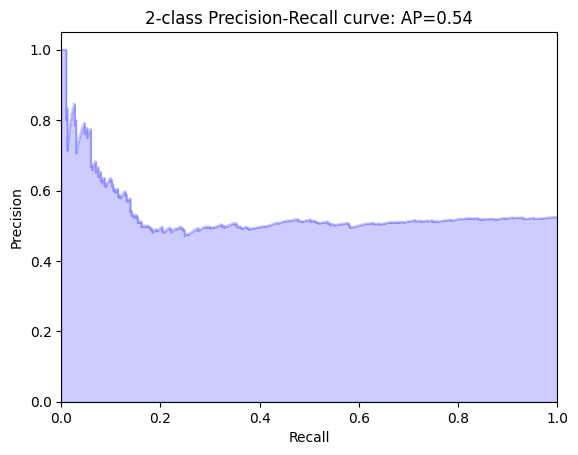

In [11]:
from sklearn.metrics import average_precision_score
average_precision_score(y_label, y_pred)
from sklearn.metrics import precision_recall_curve
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
average_precision

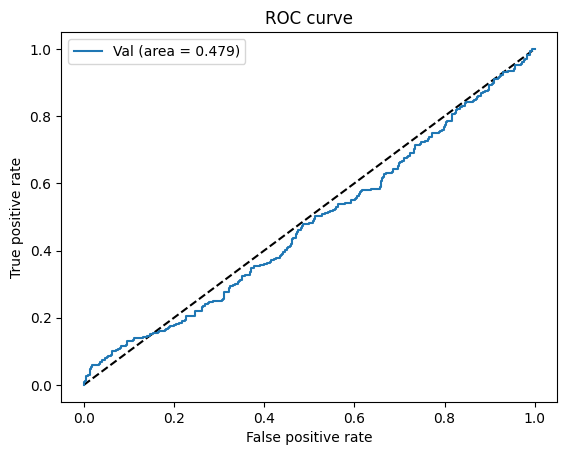

In [12]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

fpr, tpr, thresholds = roc_curve(y_label, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# Model Comparison

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [13]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

'\nif you want to use an image outside this notebook for explanaition,\nyou can read and plot it here like the Scope of Reproducibility\n'

# References

1.   Huang, K., Xiao, C., Hoang, T., Glass, L., & Sun, J. (2020, April). Caster: Predicting drug interactions with chemical substructure representation. In Proceedings of the AAAI conference on artificial intelligence (Vol. 34, No. 01, pp. 702-709).

